<a href="https://colab.research.google.com/github/rsglick/drl/blob/master/notebooks/cont_env_sb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handle installs for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb x11-utils python-opengl swig cmake ffmpeg freeglut3-dev
    !pip install Box2D box2d-py box2d-kengz gym[box2d] gym[Box_2D]
    !pip install pyvirtualdisplay PyOpenGL piglet piglet-templates PyOpenGL-accelerate
    !pip install stable-baselines3[extra]
    %matplotlib inline
else:
    %matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Imports

In [2]:
import os
import time
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import yaml
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter


# Stable Baselines3 
#  https://github.com/DLR-RM/stable-baselines3
from stable_baselines3 import PPO, SAC, TD3

from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import CallbackList

# Create Callbacks for monitoring training



In [3]:
# class TensorboardCallback(BaseCallback):
#     """
#     Custom callback for plotting additional values in tensorboard.
#     :param verbose: (int)
#     """
#     def __init__(self, log_dir, check_freq=1000, verbose=1, moving_average_window=100):
#         super(TensorboardCallback, self).__init__(verbose)
#         self.check_freq = check_freq
#         self.log_dir = log_dir   
#         self.moving_average_window = moving_average_window
        
#     def _on_training_start(self):
#         self.writer = SummaryWriter(log_dir=self.log_dir)      
        
#     def _on_step(self):
#         if self.num_timesteps % self.check_freq == 0:
#             # Retrieve training reward
#             x, y = results_plotter.ts2xy(results_plotter.load_results(self.log_dir), 'timesteps')
#             if len(x) > 0:
#                 self.writer.add_scalar("charts/episode_reward", y[-1], self.num_timesteps)
#                 self.writer.add_scalar("charts/reward_avg", np.mean(y) , self.num_timesteps )
#             if len(x) > self.moving_average_window:
#                 moving_average = np.mean(y[-self.moving_average_window:])
#                 self.writer.add_scalar("charts/reward_moving_avg", moving_average, self.num_timesteps )
                
#     def _on_training_end(self):
#         """
#         This event is triggered before exiting the `learn()` method.
#         """
#         self.writer.close()

class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """
    def __init__(self, pbar):
        super(ProgressBarCallback, self).__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager(object):
    def __init__(self, total_timesteps): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
            
        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()


# Setup Environment

In [4]:
ENV_LIST = [
    "LunarLanderContinuous-v2",
    "MountainCarContinuous-v0",    
    "Pendulum-v0",    
    "BipedalWalker-v3",
    "BipedalWalkerHardcore-v3",   
    "CarRacing-v0",
]
# all_envs = [i for i in gym.envs.registry.all()]

tmp_dict = {}
for i in ENV_LIST:
    tmp_env = gym.make(i)
    tmp_dict[i] = {
        "env_name":i,
        "action_space":tmp_env.action_space,
        "action_space_high":tmp_env.action_space.high[0],
        "action_space_low":tmp_env.action_space.low[0],
        "observation_space":tmp_env.observation_space,
        "max_episode_steps":gym.envs.registry.env_specs[i].max_episode_steps,
        "reward_threshold":gym.envs.registry.env_specs[i].reward_threshold,
    }
del tmp_env    
ENV_DF = pd.DataFrame(tmp_dict)
print(ENV_DF.T)

                                          env_name action_space  \
LunarLanderContinuous-v2  LunarLanderContinuous-v2      Box(2,)   
MountainCarContinuous-v0  MountainCarContinuous-v0      Box(1,)   
Pendulum-v0                            Pendulum-v0      Box(1,)   
BipedalWalker-v3                  BipedalWalker-v3      Box(4,)   
BipedalWalkerHardcore-v3  BipedalWalkerHardcore-v3      Box(4,)   
CarRacing-v0                          CarRacing-v0      Box(3,)   

                         action_space_high action_space_low observation_space  \
LunarLanderContinuous-v2                 1               -1           Box(8,)   
MountainCarContinuous-v0                 1               -1           Box(2,)   
Pendulum-v0                              2               -2           Box(3,)   
BipedalWalker-v3                         1               -1          Box(24,)   
BipedalWalkerHardcore-v3                 1               -1          Box(24,)   
CarRacing-v0                             1  

/home/rsglick/lib/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
ALGORITHMS = {
    'PPO': PPO,
    'SAC': SAC,
    'TD3': TD3,
}

print(ALGORITHMS)

{'PPO': <class 'stable_baselines3.ppo.ppo.PPO'>, 'SAC': <class 'stable_baselines3.sac.sac.SAC'>, 'TD3': <class 'stable_baselines3.td3.td3.TD3'>}


In [6]:
# env_name       = ENV_DF["BipedalWalkerHardcore-v3"]["env_name"]
env_name       = "LunarLanderContinuous-v2"
algorithm_name = "SAC"

env      = gym.make(env_name)

eval_env = gym.make(env_name)

if type(env.action_space) == gym.spaces.box.Box:
    print("Continuous Environment Selected.")
else:
    print("This is not a continuous environment")

# cur_env_specs = gym.envs.registry.env_specs[env_name]
reward_threshold = gym.envs.registry.env_specs[env_name].reward_threshold
if reward_threshold is None:
    reward_threshold = -200 # quick setup for Pendulum-v0

callbackFreq = 1000

timestr = time.strftime("%Y%m%d-%H%M")
name_prefix = f"{algorithm_name}_{env_name}"
log_dir = f"./runs/{env_name}/{timestr}"
hyperparam_file = f"{log_dir}/{name_prefix}.yaml"  
optim_hyperparam_file = f"{log_dir}/{name_prefix}_optimTrials.yaml"

os.makedirs(log_dir, exist_ok=True)

env      = Monitor(env, log_dir)

action_space_dim = env.action_space.shape[0]
observation_space_dim = env.observation_space.shape[0]
feature_dim = action_space_dim + observation_space_dim
print(f"{env_name}: reward_threshold {reward_threshold}")

Continuous Environment Selected.
LunarLanderContinuous-v2: reward_threshold 200


In [7]:
# tensorboard_callback =TensorboardCallback(log_dir=log_dir, 
#                                           check_freq=callbackFreq)
reward_threshold_callback = StopTrainingOnRewardThreshold(reward_threshold=reward_threshold, 
                                                          verbose=1)
checkpoint_callback = CheckpointCallback(save_freq=callbackFreq, 
                                         save_path=log_dir)
eval_callback = EvalCallback(eval_env, 
                             render=False,
                             best_model_save_path=log_dir,
                             deterministic=False,
                             callback_on_new_best=reward_threshold_callback,
                             log_path=log_dir, 
                             verbose=1,
                             n_eval_episodes=10,
                             eval_freq=callbackFreq)

# Tensorboard
Set up Tensorboard to track traing visually. 

#TODO Provide more details in Tensorflow...

In [16]:
# %tensorboard --logdir .
%tensorboard --logdir=$log_dir

# Configure Hyperparameters

In [28]:
hyperparams_dict= {}


# Hyperparams derived from the SAC paper
hyperparams_dict = {
    'learning_rate': 3.0e-4,
    'buffer_size': 1000000,
    'gamma': 0.99,
    'batch_size':256,
    'tau': 0.005,
    'device':'cuda',
    'seed':0,
    'target_entropy':"auto",
#     'policy_kwargs':dict(net_arch=[256, 256]),
     'policy_kwargs':dict(net_arch=[64, 64]),
}

# # Load Optuna Params if available otherwise save hyperparams to file 
# if os.path.exists(optim_hyperparam_file):
#     with open(optim_hyperparam_file) as f:
#         print(f"Loading hyperparams: {optim_hyperparam_file}")
#         hyperparams_dict = yaml.safe_load(f)
# else:
#     with open(hyperparam_file, 'w') as f:
#         print(f"Saving hyperparams: {hyperparam_file}")
#         yaml.dump(hyperparams_dict, f)    

        
print(f"Using the following hyperparams: {hyperparams_dict}")       
hidden_dims = hyperparams_dict['policy_kwargs']['net_arch'][0]


Using the following hyperparams: {'learning_rate': 0.0003, 'buffer_size': 1000000, 'gamma': 0.99, 'batch_size': 256, 'tau': 0.005, 'device': 'cuda', 'seed': 0, 'target_entropy': 'auto', 'policy_kwargs': {'net_arch': [64, 64]}}


In [30]:
hyperparams_dict

{'learning_rate': 0.0003,
 'buffer_size': 1000000,
 'gamma': 0.99,
 'batch_size': 256,
 'tau': 0.005,
 'device': 'cuda',
 'seed': 0,
 'target_entropy': 'auto',
 'policy_kwargs': {'net_arch': [64, 64],
  'use_sde': False,
  'device': device(type='cpu')}}

# Initialize Alogrithm

In [29]:
alogrithm = ALGORITHMS[algorithm_name]
model = alogrithm('MlpPolicy', 
                     env,
                     tensorboard_log=log_dir,               
                     #verbose=1,
                     **hyperparams_dict)

# if os.path.exists(f"{log_dir}/{name_prefix}.zip"):
#     print("Loading existing Model...")
#     model = model.load(f"{log_dir}/{name_prefix}",
#                           env=env)

In [20]:
# Setup Tensorboard Graphs for some visualizations 

try:
    with SummaryWriter(f"{log_dir}/graphs/CriticQ1") as writer:
        dummy_input = (torch.zeros(1, feature_dim))
        writer.add_graph(model.policy.critic.q1_net, input_to_model=dummy_input )

    with SummaryWriter(f"{log_dir}/graphs/CriticQ2") as writer:
        dummy_input = (torch.zeros(1, feature_dim))
        writer.add_graph(model.policy.critic.q2_net, input_to_model=dummy_input )


    with SummaryWriter(f"{log_dir}/graphs/Actor_pi") as writer:
        dummy_input = (torch.zeros(1, observation_space_dim))
        writer.add_graph(model.policy.actor.latent_pi, input_to_model=dummy_input )

    with SummaryWriter(f"{log_dir}/graphs/Actor_mu") as writer:
        dummy_input = (torch.zeros(1, hidden_dims))
        writer.add_graph(model.policy.actor.mu, input_to_model=dummy_input )

    with SummaryWriter(f"{log_dir}/graphs/Actor_log_std") as writer:
        dummy_input = (torch.zeros(1, hidden_dims))
        writer.add_graph(model.policy.actor.log_std, input_to_model=dummy_input )
except Exception as inst:
    print(f"ERROR: {inst}")
    print("Skipping Graphs")
    
# try:
#     with SummaryWriter(f"{log_dir}/hyperparams") as writer:
#         writer.add_hparams(hyperparams_dict)
# except Exception as inst:
#     print(f"ERROR: {inst}")
#     print("Skipping HyperParameters")

# Training

In [31]:
# %%time
total_timesteps = 3000000

with ProgressBarManager(total_timesteps) as progress_callback:
    callback = CallbackList([progress_callback,
                             #checkpoint_callback,
                             #plotting_callback,
#                             tensorboard_callback,
                             eval_callback])
    model.learn(total_timesteps=total_timesteps, 
                   log_interval=1,
                   callback=callback,
                   tb_log_name=algorithm_name,
                   reset_num_timesteps=True,
                   )


# Save the agent
model.save(f"{log_dir}/{name_prefix}")
del model

Eval num_timesteps=872, episode_reward=-98.92 +/- 85.90
Episode length: 95.70 +/- 7.87
Eval num_timesteps=1872, episode_reward=-220.00 +/- 133.06
Episode length: 142.50 +/- 37.07
Eval num_timesteps=2872, episode_reward=-105.77 +/- 102.45
Episode length: 233.40 +/- 54.56
Eval num_timesteps=3872, episode_reward=-85.43 +/- 99.03
Episode length: 629.50 +/- 302.21
Eval num_timesteps=4872, episode_reward=-152.86 +/- 22.57
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=5872, episode_reward=-129.86 +/- 25.00
Episode length: 403.70 +/- 71.65
Eval num_timesteps=6872, episode_reward=-127.63 +/- 31.61
Episode length: 450.50 +/- 88.39
Eval num_timesteps=7872, episode_reward=-149.21 +/- 71.11
Episode length: 625.50 +/- 196.01
Eval num_timesteps=8872, episode_reward=-87.71 +/- 20.21
Episode length: 878.90 +/- 249.03
Eval num_timesteps=9872, episode_reward=-64.03 +/- 26.73
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10872, episode_reward=-137.25 +/- 52.99
Episode len

# Evaluate Training

mean_reward 233.03 +/- 25.78


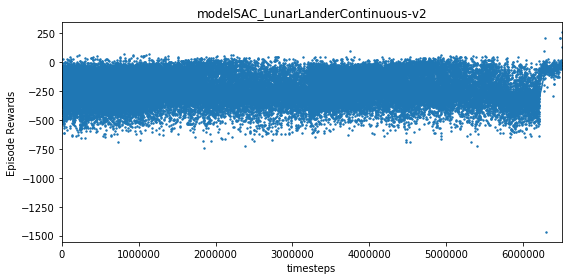

In [33]:
# %%time

# Evaluate the trained agent
model = SAC.load(f"{log_dir}/{name_prefix}")


if os.stat(f"{log_dir}/monitor.csv").st_size > 100:
    results_plotter.plot_results(dirs=[log_dir], 
                                 num_timesteps=None,
                                 x_axis=results_plotter.X_TIMESTEPS, 
                                 task_name=f"modelSAC_{env_name}",
                                 figsize=(8,4)
                                )

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, 
                                          eval_env, 
                                          render=False,
                                          n_eval_episodes=10)
# eval_env.close()
print(f"mean_reward {mean_reward:.2f} +/- {std_reward:.2f}")

In [34]:
# %%time

# Evaluate the trained agent
model = SAC.load(f"{log_dir}/{name_prefix}")



# Enjoy trained agent
def test_agent(model, 
               render: bool = False,
               timesteps: int = 1000000, 
               max_eps: int = 100,
               env_name: str = "LunarLanderContinuous-v2"):
    try:
        eval_env = gym.make(env_name)

        episode_rewards, episode_lengths = [], [] 
        episode_reward = 0.0
        episode_length = 0
        num_episodes   = 0
        obs = eval_env.reset()
        pbar = tqdm(total=timesteps)
        pbar_eps = tqdm(total=max_eps)
        #for i in tqdm(range(timesteps)):
        for i in range(timesteps):
            pbar.update()
            action, _states = model.predict(obs)
            obs, rewards, dones, info = eval_env.step(action)
            episode_reward += rewards
            episode_length += 1
            
            if render:
                eval_env.render()
            if dones:
                pbar_eps.update()
                num_episodes += 1
                pbar.write(f"Episode({num_episodes}) episode_reward = {episode_reward:.2f}, episode_length = {episode_length:.2f}")

                episode_rewards.append(episode_reward)
                episode_lengths.append(episode_length)

                episode_reward = 0.0
                episode_length = 0
                eval_env.reset()
                
                if num_episodes == max_eps:
                    break

            if i % 1000 == 0:
                pbar.write(f"Step {i}")
        pbar.refresh()
        pbar.close()
        pbar_eps.refresh()
        pbar_eps.close()
        eval_env.close()

        mean_reward = np.mean(episode_rewards)
        std_reward = np.std(episode_rewards)

        print(f"Total Eps({num_episodes}): mean_reward = {mean_reward:.2f} +/- {std_reward:.2f}")

    except KeyboardInterrupt:
        pbar.refresh()
        pbar.close()
        pbar_eps.refresh()
        pbar_eps.close()
        eval_env.close()
        return

test_agent(model,
           max_eps=10,
           env_name=env_name,
           render=True)


Step 0
Episode(1) episode_reward = 260.81, episode_length = 419.00
Episode(2) episode_reward = 252.32, episode_length = 494.00
Step 1000
Episode(3) episode_reward = 238.69, episode_length = 548.00
Step 2000
Episode(4) episode_reward = -31.75, episode_length = 1000.00
Step 3000
Episode(5) episode_reward = 198.21, episode_length = 575.00
Step 4000
Episode(6) episode_reward = 44.03, episode_length = 1000.00
Episode(7) episode_reward = 238.08, episode_length = 441.00
Episode(8) episode_reward = 248.68, episode_length = 509.00
Step 5000
Episode(9) episode_reward = 246.67, episode_length = 452.00
Episode(10) episode_reward = 209.68, episode_length = 531.00


Total Eps(10): mean_reward = 190.54 +/- 95.48


# Record agents in action


In [35]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [36]:
#video_folder = f"{env_name}_output"
video_folder = log_dir

# record_video(env_name, modelTD3, video_length=1000, prefix=f'td3_{env_name}', video_folder=video_folder)
# record_video(env_name, modelPPO, video_length=1000, prefix=f'ppo_{env_name}', video_folder=video_folder)
record_video(env_name, model, video_length=2000, prefix=name_prefix, video_folder=log_dir)

In [37]:
show_videos(log_dir, prefix=name_prefix)